https://www.kaggle.com/vincepota/predicting-customers-who-will-charge-off

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

import matplotlib.pylab as plt
%matplotlib inline

In [25]:
train_df = pd.read_csv('../dump/train_modified.csv')
test_df = pd.read_csv('../dump/test_modified.csv')
label = pd.read_csv('../input/test_label.csv')

In [26]:
target='acc_now_delinq'
IDcol = 'member_id'
train_df[target].value_counts()


0.0    706610
1.0      3293
Name: acc_now_delinq, dtype: int64

In [27]:
#Combine into data:
train_df['source']= 'train'
test_df['source'] = 'test'
df=pd.concat([train_df,test_df],ignore_index=True)

In [28]:
test_df.shape, label.shape

((177476, 90), (177476, 2))

In [29]:
predictors = [x for x in train_df.columns if x not in [target,IDcol, 'source']]

In [30]:
X_scaled = preprocessing.scale(df[predictors])  # 标准化的过程为两步：去均值的中心化（均值变为0）；方差的规模化（方差变为1）。
print(X_scaled)
print('   ')
print(X_scaled.shape)

[[-0.14904726 -0.3095537  -0.02164747 ... -0.05149642  0.97077001
  -0.97077001]
 [-0.14904726 -0.49503049 -0.02164747 ... -0.05149642  0.97077001
  -0.97077001]
 [-0.14904726  0.40607759 -0.02164747 ... -0.05149642 -1.03011011
   1.03011011]
 ...
 [-0.14904726 -0.33737521 -0.02164747 ... -0.05149642  0.97077001
  -0.97077001]
 [-0.14904726 -0.677416   -0.02164747 ... -0.05149642  0.97077001
  -0.97077001]
 [-0.14904726 -0.0931641  -0.02164747 ... -0.05149642  0.97077001
  -0.97077001]]
   
(887379, 88)


In [31]:
x_train = df.loc[df['source']=='train'][predictors]
y_train = df.loc[df['source']=='train'][target]
x_test = df.loc[df['source']=='test'][predictors]
y_test = label[target]

In [32]:
 df.shape ,x_test.shape

((887379, 91), (177476, 88))

In [42]:
from sklearn.linear_model import LogisticRegression
import numpy as np
# model = LogisticRegression(class_weight={0: 0.15, 1: 0.85})
model = LogisticRegression(class_weight='balanced', verbose=1, n_jobs=-1, penalty ='l1')
model.fit(x_train, y_train)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=1, warm_start=False)

In [43]:
from sklearn import metrics
p_train=model.predict(x_train)
p_test = model.predict(x_test)

In [47]:
roc=metrics.roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
print(roc)
print(metrics.classification_report(y_train,p_train))
print('*'*8)
print(metrics.classification_report(y_test,p_test))

0.8040102043831107
             precision    recall  f1-score   support

        0.0       1.00      0.73      0.84    706610
        1.0       0.01      0.74      0.02      3293

avg / total       0.99      0.73      0.84    709903

********
             precision    recall  f1-score   support

          0       1.00      0.73      0.84    176655
          1       0.01      0.71      0.02       821

avg / total       0.99      0.73      0.84    177476



In [6]:
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'):
    
    clfs = {'GradientBoosting': GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3),
            'LogisticRegression' : LogisticRegression(),
            #'GaussianNB': GaussianNB(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=10)
            }
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        print('computing {} - {} '.format(clf_name, model_type))

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix

computing GradientBoosting - Non-balanced 
computing LogisticRegression - Non-balanced 
computing RandomForestClassifier - Non-balanced 


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in true_divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


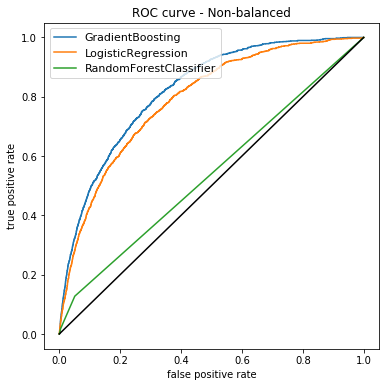

In [9]:
#mpl.rc("savefig", dpi=300)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, train_df[target].values, test_size=0.4, random_state=0)
models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')

In [10]:
models_report

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,GradientBoosting,0.001441,0.820998,0.007812,0.001554,0.002592,Non-balanced
1,LogisticRegression,-0.000222,0.789550,0.000000,0.000000,0.000000,Non-balanced
2,RandomForestClassifier,0.000000,0.538451,0.000000,0.000000,0.000000,Non-balanced


In [11]:
conf_matrix['LogisticRegression']

Predicted,0.0,1.0
True,,
0.0,279096,3
1.0,1287,0


computing GradientBoosting - Balanced 
computing LogisticRegression - Balanced 


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: overflow encountered in longlong_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


computing RandomForestClassifier - Balanced 


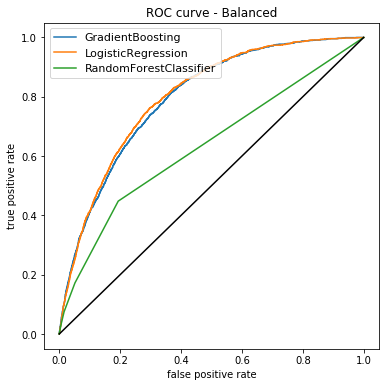

In [13]:
index_split = int(len(train_df[predictors])/2)
X_train, y_train = SMOTE().fit_sample(X_scaled[0:index_split, :], train_df[target][0:index_split])
X_test, y_test = X_scaled[index_split:], train_df[target][index_split:]

#scores = cross_val_score(clf, X_scaled, y , cv=5, scoring='roc_auc')

models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')

In [14]:
models_report_bal

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,GradientBoosting,0.052551,0.794996,0.030808,0.122849,0.049262,Balanced
1,LogisticRegression,0.394448,0.800115,0.012854,0.727596,0.025262,Balanced
2,RandomForestClassifier,0.011234,0.632966,0.035398,0.004748,0.008373,Balanced


In [15]:
conf_matrix_bal['LogisticRegression']

Predicted,0.0,1.0
True,,
0.0,254647,94151
1.0,459,1226
